In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
def Emax(img, l = 3):
    Emaxs = []
    imgarr = np.copy(img)
    for i in range(0,l):
        coeffs2 = pywt.dwt2(imgarr, 'haar')
        LL, (LH, HL, HH) = coeffs2
        imgarr = LL
        Emax = np.sqrt( LH**2 + HL**2 + HH**2 )
        Emaxs.append(Emax)
    return Emaxs
def edges_points(emaxs_o,thr):
    edges = []
    emaxs = np.copy(emaxs_o)
    for emax in emaxs:
        emax[emax<thr] = 0
        emax[emax>=thr] = 1
        edges.append(emax)
    
    return edges

In [8]:
import PIL
from PIL import Image
def open_img(path):
    img = PIL.Image.open(path).convert("L")
    return np.array(img) 

In [9]:
def OR(edges):
    aux = np.copy(edges)
    result = edges[0]
    for edge in edges[1:]:
        result = np.array(np.logical_or(result,edge),dtype = np.int)
    return result

In [10]:
def roof_gstep(emaxs, edges_o):
    emax1,emax2,emax3 = np.copy(emaxs)
    edges = np.copy(edges_o)
    emax1[edges!=1]=0
    emax2[edges!=1]=0
    emax3[edges!=1]=0
    
    emax1[emax1<emax2]=1
    emax1[emax1>=emax2]=0
    
    emax2[emax2<emax3]=1
    emax2[emax2>=emax3]=0
    
    return np.array(np.logical_and(emax1,emax2),dtype = np.int)

def roof(emaxs, edges_o):
    emax1,emax2,emax3 = np.copy(emaxs)
    edges = np.copy(edges_o)
    emax1[edges!=1]=0
    emax2[edges!=1]=0
    emax3[edges!=1]=0
    
    emax1[emax1<emax2]=1
    emax1[emax1>=emax2]=0
    
    emax2[emax2>emax3]=1
    emax2[emax2<=emax3]=0
    
    return np.array(np.logical_and(emax1,emax2),dtype = np.int)

def dirac_astep(emaxs, edges_o):
    emax1,emax2,emax3 = np.copy(emaxs)
    edges = np.copy(edges_o)
    emax1[edges!=1]=0
    emax2[edges!=1]=0
    emax3[edges!=1]=0
    
    emax1[emax1>emax2]=1
    emax1[emax1<=emax2]=0
    
    emax2[emax2>emax3]=1
    emax2[emax2<=emax3]=0
    
    return np.array(np.logical_and(emax1,emax2),dtype = np.int)

def blr_edges(emax1_o,rrg_o,thr):
    emax1 =  np.copy(emax1_o)
    rrg = np.copy(rrg_o)
    
    emax1[emax1<thr]=1
    emax1[emax1>=thr]=0
    emax1[rrg!=1]=0

    return emax1

0.0 0.7932481772580957


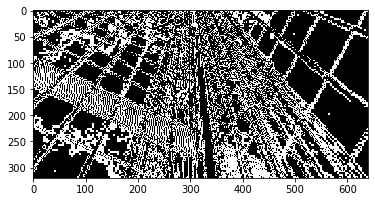

In [26]:
def blur_detection(path,thr=50):

    img = open_img(path)
    
    ##etapa 1
    emax1,emax2,emax3 = Emax(img,3)
    """
    emax3r = np.copy(emax3)
    h,w = emax3r.shape
    emax1r = cv2.resize(emax1, dsize = (w,h),interpolation = cv2.INTER_NEAREST)
    emax2r = cv2.resize(emax2, dsize = (w,h),interpolation = cv2.INTER_NEAREST)
    """

    emax1r = np.copy(emax1)
    h,w = emax1r.shape
    emax2r = cv2.resize(emax2, dsize = (w,h),interpolation = cv2.INTER_NEAREST)
    emax3r = cv2.resize(emax3, dsize = (w,h),interpolation = cv2.INTER_NEAREST)
 
    ##etapa 2

    edge1,edge2,edge3 = edges_points([emax1r,emax2r,emax3r],thr)
    edges = OR([edge1,edge2,edge3])
    Nedges = np.sum(edges)

    ##etapa 3
    dirac_a = dirac_astep([emax1r,emax2r,emax3r],edges)
    Nda = np.sum(dirac_a)

    ##etapa 4

    roofe = roof([emax1r,emax2r,emax3r],edges)
    roof_g = roof_gstep([emax1r,emax2r,emax3r],edges)
    roof_roofg = OR([roofe,roof_g])
    Nrg = np.sum(roof_roofg)
   
    ##etapa 5
    blr = blr_edges(emax1r,roof_roofg,thr)
    Nbrg = np.sum(blr)
    plt.imshow(blr,cmap='gray')
    
    ##etapa 6
    Per = Nda/Nedges
    
    ##etapa 7 
    BlurExtend = Nbrg/Nrg
    
    return Per,BlurExtend

per, blur_e = blur_detection('teste.jpg',35)
print(per,blur_e)